In [132]:
from torch_geometric.data import HeteroData
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
users_pd = pd.read_csv("C:/Users/josep/amazon_dataset_latest/users.csv")
products_pd = pd.read_csv("C:/Users/josep/amazon_dataset_latest/all_products.csv")
user_product_edge_pd = pd.read_csv("C:/Users/josep/amazon_dataset_latest/user_product_edges.csv")
also_bought_edges_pd = pd.read_csv("C:/Users/josep/amazon_dataset_latest/also_bought_edges.csv")
also_viewed_edges_pd = pd.read_csv("C:/Users/josep/amazon_dataset_latest/also_viewed_edges.csv")
bought_together_edges_pd = pd.read_csv("C:/Users/josep/amazon_dataset_latest/bought_together_edges.csv")

In [28]:
user_product_edge_pd.head()

,overall,reviewerID,asin,date,helpfulness_ratio
0,5,A2XVJBSRI3SWDI,0000031887,2013-11-04,0.0
1,2,A2R3K1KX09QBYP,0000031887,2013-02-17,1.0
2,1,A19PBP93OF896,0000031887,2013-03-21,0.0
3,4,A1P0IHU93EF9ZK,0000031887,2014-01-23,0.0
4,5,A2G5TCU2WDFZ65,0000031887,2013-01-19,0.0


In [15]:
also_bought_edges_pd.head()

,asin,also_bought
0,0000031887,B003AVKOP2
1,0000031887,B00D103F8U
2,0000031887,B008F0SU0Y
3,0000031887,B003AVEU6G
4,0000031887,B002C3Y6WG


In [17]:
also_viewed_edges_pd.head()

,asin,also_viewed
0,0000037214,B00JO8II76
1,0000031887,B00538F5OK
2,0000031887,B003AVKOP2
3,0000031887,B008F0SU0Y
4,0000031887,B002GZPTRQ


In [18]:
bought_together_edges_pd.head()

,asin,bought_together
0,0123456479,B000BMTCK6
1,0123456479,B0006JCGUM
2,1608322130,B003USWPHA
3,245600258X,B004LK9GZ0
4,3293015344,B007VE0OI6


In [70]:
class AsinIdMap:
    def __init__(self, products_pd):
        self.products_pd = products_pd
        self.asin_to_idx = {}
        self.product_idx_to_asin = {}
        self._build()
    
    def _build(self):
        for idx, row in self.products_pd.iterrows():
            self.asin_to_idx[row['asin']] = idx
            self.product_idx_to_asin[idx] = row['asin']
    
    def get_idx(self, asin):
        return self.asin_to_idx[asin]
    
    def get_asin(self, product_idx):
        return self.product_idx_to_asin[product_idx]
    
    def get_count(self):
        return len(self.asin_to_idx)
    
def build_product_to_product_edge_index(edges_pd, asin_id_map, right_key):
    product_to_product_edge_index = []
    errors = []
    unique_products = {}
    for idx, row in edges_pd.iterrows():
        try:
            asin1 = row['asin']
            product1_idx = asin_id_map.get_idx(asin1)
        except:
            #errors.append(f"Cannot map {asin1} to product idx")
            continue
        
        try:
            asin2 = row[right_key]
            product2_idx = asin_id_map.get_idx(asin2)
        except:
            #errors.append(f"Cannot map {asin2} to product idx")
            continue
        
        unique_products[asin1] = 1
        unique_products[asin2] = 1
        
        product_to_product_edge_index.append([product1_idx, product2_idx])
        
    return torch.tensor(product_to_product_edge_index).t().contiguous(), unique_products, errors

In [45]:
asin_id_map = AsinIdMap(products_pd)

In [69]:
also_bought_edges_tensor, unique_products1, errors =  build_product_to_product_edge_index(also_bought_edges_pd, asin_id_map, 'also_bought')

In [73]:
#also_viewed_edges_tensor, unique_products2, errors =  build_product_to_product_edge_index(also_viewed_edges_pd, asin_id_map, 'also_viewed')

In [68]:
bought_together_edges_tensor, unique_products3, errors =  build_product_to_product_edge_index(bought_together_edges_pd, asin_id_map, 'bought_together')

In [71]:
unique_products = []
unique_products.extend(unique_products1)
#unique_products.extend(unique_products2)
unique_products.extend(unique_products3)
unique_products = list(set(unique_products))

In [3]:
data = HeteroData()

In [74]:
# Dimension for product features
product_feature_dim = 128
num_products = len(unique_products)

data['product'].x = torch.randn(num_products, product_feature_dim)

# Similar products
# data['product', 'also_viewed', 'product'].edge_index = also_viewed_edges_tensor

# Complementary products
data['product', 'bought_together', 'product'].edge_index = bought_together_edges_tensor
data['product', 'also_bought', 'product'].edge_index = also_bought_edges_tensor

data

HeteroData(
  product={ x=[588359, 128] },
  (product, also_viewed, product)={ edge_index=[2, 1000] },
  (product, bought_together, product)={ edge_index=[2, 554094] },
  (product, also_bought, product)={ edge_index=[2, 6279224] }
)

### Using NetworkX to manipulate the graph

In [75]:
import networkx as nx
G = nx.Graph()

In [109]:
also_bought_edges = []
for idx, row in also_bought_edges_pd.iterrows():
    asin = row['asin']
    also_bought = row['also_bought']
    also_bought_edges.append((asin, also_bought))

In [110]:
bought_together_edges = []
for idx, row in bought_together_edges_pd.iterrows():
    asin = row['asin']
    bought_together = row['bought_together']
    bought_together_edges.append((asin, bought_together))

In [154]:
G.add_edges_from(also_bought_edges, edge_type='also_bought')
#G.add_edges_from(bought_together_edges, edge_type='bought_together')
H = G.to_undirected()

In [163]:
node_degrees = [degree for node, degree in dict(H.degree()).items()]
min_value = np.min(node_degrees)
max_value = np.max(node_degrees)
print(f"Minimum: {min_value}")
print(f"Maximum: {max_value}")

# Calculate and print quartiles
Q1 = np.percentile(node_degrees, 25)  # First quartile
Q2 = np.percentile(node_degrees, 50)  # Second quartile (median)
Q3 = np.percentile(node_degrees, 75)  # Third quartile
Q4 = np.percentile(node_degrees, 95)  # Fourth quartile
Q5 = np.percentile(node_degrees, 99)  # Fourth quartile

print(f"First Quartile (Q1): {Q1}")
print(f"Median (Q2): {Q2}")
print(f"Third Quartile (Q3): {Q3}")
print(f"95th Percentile (Q4): {Q4}")
print(f"99th Percentile (Q5): {Q5}")


Minimum: 0
Maximum: 7661
First Quartile (Q1): 13.0
Median (Q2): 20.0
Third Quartile (Q3): 33.0
95th Percentile (Q4): 105.0
99th Percentile (Q5): 486.0


Text(0.5, 1.0, 'Degree distribution for also_bought edges')

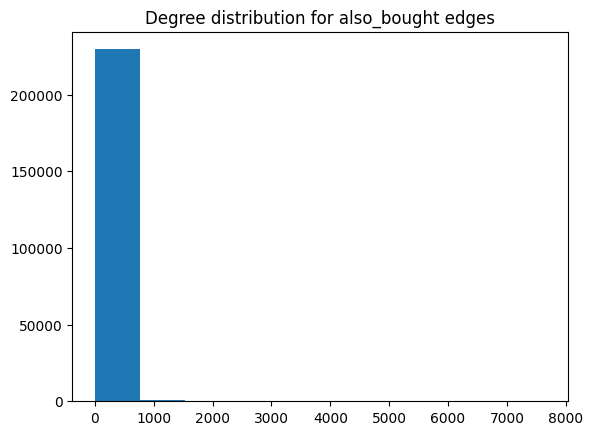

In [162]:
# Plot node_degrees

plt.hist(node_degrees, bins = 10)
plt.title("Degree distribution for also_bought edges")

In [164]:
# Specify the minimum degree threshold
min_degree = 13
max_degree = 486
# Find nodes with degree less than the threshold
nodes_to_remove = [node for node, degree in dict(H.degree()).items() if degree < min_degree or degree > max_degree]

# Remove these nodes from the graph
H.remove_nodes_from(nodes_to_remove)

Text(0.5, 1.0, 'Degree distribution for also_bought edges(after filtering)')

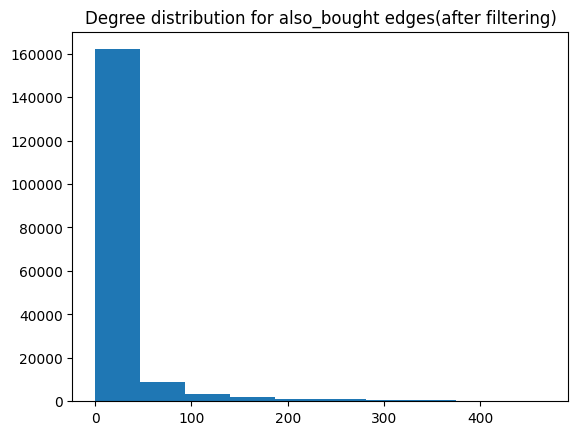

In [166]:

node_degrees = [degree for node, degree in dict(H.degree()).items()]
plt.hist(node_degrees, bins = 10)
plt.title("Degree distribution for also_bought edges(after filtering)")

In [168]:
len(G.nodes)

588359